<h1 align="center">DAC Author Network Analysis</h1> 

Reference:    
[1] Modularity and community structure in networks http://www.pnas.org/content/103/23/8577.full.pdf    
[2] The structure of scientific collaboration networks http://www.pnas.org/content/98/2/404.full.pdf    
[3] D. Liben-Nowell, J. Kleinberg. The Link Prediction Problem for Social Networks (2004). http://www.cs.cornell.edu/home/kleinber/link-pred.pdf

In [1]:
%matplotlib inline

In [97]:
import matplotlib.pyplot as plt
import networkx as nx
from DAC import Author
from DAC import Paper
import pandas as pd
import pickle
import pyprind
import community
import operator

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [3]:
with open("../Data/Author_Data.pickle", "rb") as f:
    authors = pickle.load(f)

In [4]:
with open("../Data/Paper_Data.pickle", "rb") as f:
    papers = pickle.load(f)

# Network Construction

In [5]:
def make_pairs(input_list):
    length = len(input_list)
    ret = []
    if length == 1:
        return [(input_list[0], input_list[0])]
    for i in range(0, length-1):
        for j in range(i+1, length):
            ret.append((input_list[i], input_list[j]))
    return ret

def papers_by_year(papers, inf, sup):
    ret = []
    for p in papers.values():
        if p.year <= sup and p.year >= inf:
            ret.append(p)
    return ret

def make_edges(papers_selected):
    edge_list = []
    for p in papers_selected:
        edge_list.extend(make_pairs(p.author_ids))
    return edge_list

def author_network(papers, inf_year, sup_year):
    papers_between = papers_by_year(papers, inf_year, sup_year)
    edge_list = make_edges(papers_between)
    
    G=nx.Graph()
    for edge in edge_list:
        G.add_edge(edge[0], edge[1])
    return G

# Author Search

In [103]:
def author_search(authors, name):
    name_set = []
    for author in authors.values():
        name_set.append(author.name)
    candidates = process.extract(name, name_set, limit=2)
    
    result = {}
    for candidate in candidates:
        cur = candidate[0]
        for author in authors.values():
            if author.name == cur:
                result[author.aid] = author.__dict__
    return result

def display_author(authors, aid):
    return authors[aid].__dict__

In [86]:
author_search(authors, "james allison")

{'2511': {'aid': '2511',
  'name': u'Jingzhou (James) Yang',
  'nicknames': [],
  'paper_ids': [u'DETC2012-70560 pp. 641-652; (12 pages)']},
 '3': {'aid': '3',
  'name': u'James Allison',
  'nicknames': [u'James T. Allison'],
  'paper_ids': [u'DETC2005-84790 pp. 265-275; (11 pages)',
   u'DETC2015-46832, pp. V02BT03A024',
   u'DETC2008-49823 pp. 917-926; (10 pages)',
   u'DETC2013-12262 pp. V03BT03A011; (11 pages)',
   u'DETC2007-34698 pp. 709-718; (10 pages)',
   u'DETC2014-35314 pp. V02BT03A039; (14 pages)',
   u'DETC2011-48521 pp. 903-913; (11 pages)',
   u'DETC2010-29055 pp. 715-728; (14 pages)',
   u'DETC2015-46768, pp. V02BT03A008',
   u'DETC2010-28887 pp. 765-774; (10 pages)',
   u'DETC2014-34256 pp. V02AT03A006; (12 pages)',
   u'DETC2012-71108 pp. 847-856; (10 pages)',
   u'DETC2010-28788 pp. 755-764; (10 pages)',
   u'DETC2013-13462 pp. V03AT03A058; (10 pages)',
   u'DETC2013-12600 pp. V03AT03A018; (11 pages)']}}

# 1. Total papers

In [6]:
len(papers)

1668

From 2002 to 2015, there are 1668 papers in DAC.

In [7]:
def year_paper_stats():
    stats = {}
    for p in papers.values():
        stats[p.year] = 0
        
    for p in papers.values():
        stats[p.year] += 1
    
    return stats

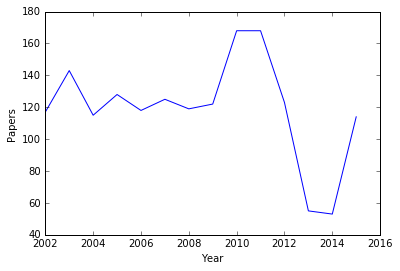

In [8]:
yt = year_paper_stats()
plt.plot(yt.keys(), yt.values())
plt.ylabel('Papers')
plt.xlabel('Year')

In [9]:
pd.DataFrame(yt.items(), columns=['Year', 'Papers'])

,Year,Papers
0,2002,117
1,2003,143
2,2004,115
3,2005,128
4,2006,118
5,2007,125
6,2008,119
7,2009,122
8,2010,168
9,2011,168


# 2. Total authors

In [10]:
len(authors)

2374

From 2002 to 2015, there are 2374 authors in DAC.

In [11]:
def year_author_stats():
    year_au = {}
    for p in papers.values():
        year_au[p.year] = set()
        
    for p in papers.values():
        for au in p.author_ids:
            year_au[p.year].add(au)
    
    stats = {}
    for y in year_au.keys():
        stats[y] = len(year_au[y])
    return stats

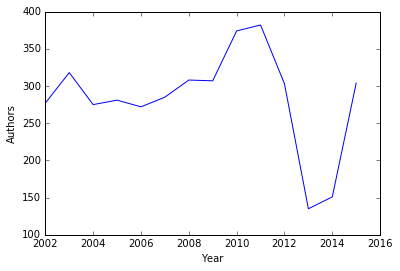

In [12]:
yt = year_author_stats()
plt.plot(yt.keys(), yt.values())
plt.ylabel('Authors')
plt.xlabel('Year')

In [13]:
pd.DataFrame(yt.items(), columns=['Year', 'Authors'])

,Year,Authors
0,2002,277
1,2003,318
2,2004,275
3,2005,281
4,2006,272
5,2007,285
6,2008,308
7,2009,307
8,2010,374
9,2011,382


# 3. Mean papers per author

In [14]:
def avg_stats():
    stats = {}
    
    au_stats = year_author_stats()
    pp_stats = year_paper_stats()
    
    for year in au_stats.keys():
        stats[year] = float(pp_stats[year])/au_stats[year]
        
    return stats

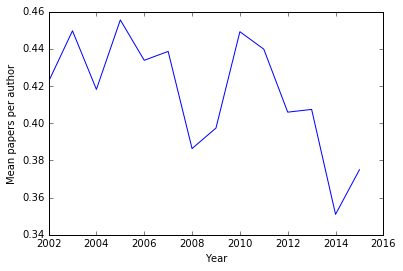

In [15]:
yt = avg_stats()
plt.plot(yt.keys(), yt.values())
plt.ylabel('Mean papers per author')
plt.xlabel('Year')

In [16]:
pd.DataFrame(yt.items(), columns=['Year', 'Mean papers per author'])

,Year,Mean papers per author
0,2002,0.422383
1,2003,0.449686
2,2004,0.418182
3,2005,0.455516
4,2006,0.433824
5,2007,0.438596
6,2008,0.386364
7,2009,0.397394
8,2010,0.449198
9,2011,0.439791


# 4. Mean authors per paper

In [17]:
mean_au_per_paper = {}
for year in yt.keys():
    mean_au_per_paper[year] = 1/yt[year]

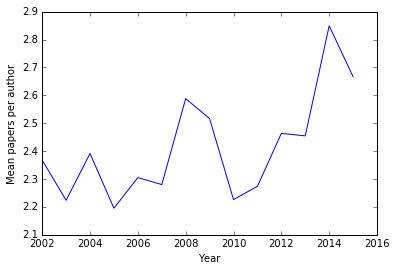

In [18]:
plt.plot(mean_au_per_paper.keys(), mean_au_per_paper.values())
plt.ylabel('Mean papers per author')
plt.xlabel('Year')

In [19]:
pd.DataFrame(mean_au_per_paper.items(), columns=['Year', 'Mean authors per paper'])

,Year,Mean authors per paper
0,2002,2.367521
1,2003,2.223776
2,2004,2.391304
3,2005,2.195312
4,2006,2.305085
5,2007,2.280000
6,2008,2.588235
7,2009,2.516393
8,2010,2.226190
9,2011,2.273810


# 5. Collaborators per author

In [20]:
g = author_network(papers, 0, 2015)

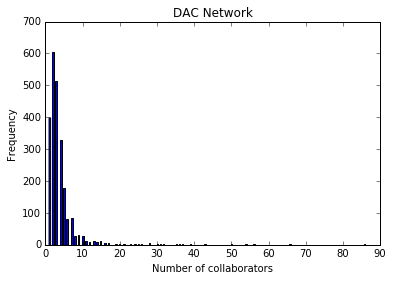

In [21]:
plt.hist(g.degree().values(), bins=200)
plt.title("DAC Network")
plt.xlabel("Number of collaborators")
plt.ylabel("Frequency")
plt.show()

In [22]:
degree_under_15 = [i for i in g.degree().values() if i <= 15]

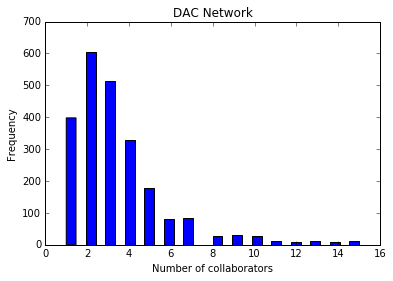

In [23]:
plt.hist(degree_under_15, bins=30)
plt.title("DAC Network")
plt.xlabel("Number of collaborators")
plt.ylabel("Frequency")
plt.show()

# 6. Size of giant component

In [24]:
def size_of_giant_component(inf_year, sup_year):
    g = author_network(papers, inf_year, sup_year)
    cc = nx.connected_component_subgraphs(g)
    comps = [len(c) for c in sorted(nx.connected_components(g), key=len, reverse=True)]
    return comps[0]

In [25]:
size_of_giant_component(0, 2015)

1191

In [26]:
for year in range(2002, 2016):
    print year, size_of_giant_component(year, year)

2002 9
2003 17
2004 12
2005 16
2006 50
2007 10
2008 20
2009 30
2010 32
2011 20
2012 13
2013 15
2014 16
2015 12


# 7. Second largest component 

In [27]:
def size_of_2nd_largest_component(inf_year, sup_year):
    g = author_network(papers, inf_year, sup_year)
    cc = nx.connected_component_subgraphs(g)
    comps = [len(c) for c in sorted(nx.connected_components(g), key=len, reverse=True)]
    return comps[1]

In [28]:
for year in range(2002, 2016):
    print year, size_of_2nd_largest_component(year, year)

2002 7
2003 11
2004 12
2005 15
2006 22
2007 10
2008 13
2009 16
2010 20
2011 15
2012 12
2013 10
2014 12
2015 12


# 8. Mean distance

In [30]:
def mean_dist_year(starting_yr, ending_yr):
    g = author_network(papers, starting_yr, ending_yr)
    
    nodes = g.nodes()
    pairs = make_pairs(nodes)

    dist_list = []
    for p in pairs:
        try:
            dist_list.append(nx.shortest_path_length(g, source = str(p[0]), target = str(p[1])))
        except:
            pass

    return float(sum(dist_list))/len(dist_list)

In [35]:
mean_dists = {}

n = 14
bar = pyprind.ProgBar(n)

for ending in range(2002, 2016):
    bar.update()
    mean_dists[ending] = mean_dist_year(ending, ending)

0%          100%
[##############] | ETA: 00:00:00
Total time elapsed: 00:00:05


In [36]:
mean_dists

{2002: 1.2137592137592137,
 2003: 1.5094043887147335,
 2004: 1.4327586206896552,
 2005: 1.6130867709815078,
 2006: 2.756365740740741,
 2007: 1.3485915492957747,
 2008: 1.3961424332344214,
 2009: 1.752808988764045,
 2010: 1.946969696969697,
 2011: 1.562396006655574,
 2012: 1.4226190476190477,
 2013: 1.3417721518987342,
 2014: 1.459090909090909,
 2015: 1.3496598639455781}

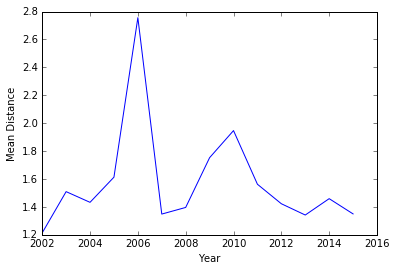

In [37]:
plt.plot(mean_dists.keys(), mean_dists.values())
plt.ylabel('Mean Distance')
plt.xlabel('Year')

# 9. Maximum distance

In [49]:
def max_dist_year(starting_yr, ending_yr):
    g = author_network(papers, starting_yr, ending_yr)
    
    nodes = g.nodes()
    pairs = make_pairs(nodes)

    dist_list = []
    for p in pairs:
        try:
            dist_list.append(nx.shortest_path_length(g, source = str(p[0]), target = str(p[1])))
        except:
            pass

    return max(dist_list)

In [50]:
max_dists = {}

n = 14
bar = pyprind.ProgBar(n)

for ending in range(2002, 2016):
    bar.update()
    max_dists[ending] = max_dist_year(ending, ending)

0%          100%
[##############] | ETA: 00:00:00
Total time elapsed: 00:00:05


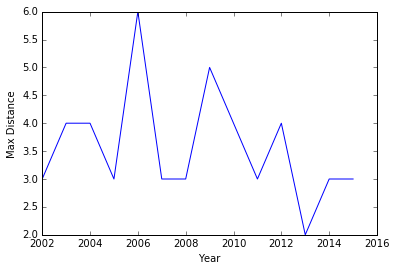

In [51]:
plt.plot(max_dists.keys(), max_dists.values())
plt.ylabel('Max Distance')
plt.xlabel('Year')

# 10. Clustering coefficient C

In [42]:
def clustering_coefficient_year(starting_yr, ending_yr):
    g = author_network(papers, starting_yr, ending_yr)
    return nx.average_clustering(g)

In [43]:
clustering_coefficients = {}

n = 14
bar = pyprind.ProgBar(n)

for ending in range(2002, 2016):
    bar.update()
    clustering_coefficients[ending] = clustering_coefficient_year(ending, ending)

0%          100%
[##############] | ETA: 00:00:00
Total time elapsed: 00:00:00


In [44]:
clustering_coefficients

{2002: 0.6217637957710159,
 2003: 0.6510107816711589,
 2004: 0.647267217630854,
 2005: 0.6128400662208492,
 2006: 0.69583725527998,
 2007: 0.6579420774157615,
 2008: 0.7452695591793338,
 2009: 0.6986596889868382,
 2010: 0.7448439558065226,
 2011: 0.7462553444228837,
 2012: 0.7244417298872746,
 2013: 0.7371627549405326,
 2014: 0.7270491098305669,
 2015: 0.779446960203539}

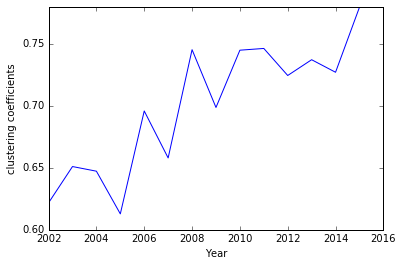

In [47]:
plt.plot(clustering_coefficients.keys(), clustering_coefficients.values())
plt.ylabel('clustering coefficients')
plt.xlabel('Year')

# 11. Link Prediction

In [79]:
def jaccard_coefficient_year(starting_yr, ending_yr):
    g = author_network(papers, starting_yr, ending_yr)
    preds = nx.jaccard_coefficient(g)
    return preds

In [108]:
def similar_authors(aid):
    result = {}
    preds = jaccard_coefficient_year(2002, 2015)
    for pred in preds:
        if aid in pred:
            if pred[2] > 0:
                for partner in pred[0:2]:
                    if partner != aid:
                        result[partner] = pred[2]
    
    sorted_result = sorted(result.items(), key=operator.itemgetter(1), reverse=True)
    for res in sorted_result:
        name = display_author(authors, res[0])['name']
        score = res[1]
        print name, score
    return sorted_result

In [111]:
info = similar_authors('3')

Jing Li 0.125
Bart D. Frischknecht 0.105263157895
Alexis Perez-Duarte 0.105263157895
Zhijun Li 0.1
Richard Gerth 0.1
Honglak Lee 0.1
Luis E. Izquierdo 0.1
Matthew P. Reed 0.0952380952381
Ryan Fellini 0.0952380952381
Alex Burnap 0.0952380952381
Yi Ren 0.0869565217391
Huibin Liu 0.0869565217391
W. Ross Morrow 0.0869565217391
Dorin Drignei 0.0833333333333
Vijitashwa Pandey 0.0769230769231
S. Jack Hu 0.0689655172414
Matthew B. Parkinson 0.0689655172414
Harrison M. Kim 0.0689655172414
Zissimos P. Mourelatos 0.0652173913043
Le Chen 0.0555555555556
Cassio D. Goncalves 0.0555555555556
Jeongwoo Han 0.0555555555556
Subroto Gunawan 0.0555555555556
Gautam Marwaha 0.0555555555556
Bastien Talgorn 0.0526315789474
Sébastien Le Digabel 0.0526315789474
Joshua Mineroff 0.0526315789474
Minhua Long 0.0526315789474
Clayton Scott 0.0526315789474
Andreas A. Malikopoulos 0.0526315789474
Fred M. Feinberg 0.0526315789474
Yoram Koren 0.05
Oben Ceryan 0.05
Adam B. Cooper 0.05
John W. Whitefoot 0.05
Namwoo Kang 0.0